# Task 1

Loading Image...
Preparing Datasets...
Initializing Model...
Starting Training...
Iteration [1/2000], Loss: 0.0633, Train PSNR: 11.99, Test PSNR: 12.01
Iteration [11/2000], Loss: 0.0605, Train PSNR: 12.18, Test PSNR: 12.19
Iteration [21/2000], Loss: 0.0588, Train PSNR: 12.31, Test PSNR: 12.32
Iteration [31/2000], Loss: 0.0576, Train PSNR: 12.40, Test PSNR: 12.40
Iteration [41/2000], Loss: 0.0565, Train PSNR: 12.48, Test PSNR: 12.49
Iteration [51/2000], Loss: 0.0554, Train PSNR: 12.56, Test PSNR: 12.57
Iteration [61/2000], Loss: 0.0545, Train PSNR: 12.63, Test PSNR: 12.64
Iteration [71/2000], Loss: 0.0539, Train PSNR: 12.69, Test PSNR: 12.69
Iteration [81/2000], Loss: 0.0534, Train PSNR: 12.72, Test PSNR: 12.72
Iteration [91/2000], Loss: 0.0531, Train PSNR: 12.75, Test PSNR: 12.75
Iteration [101/2000], Loss: 0.0529, Train PSNR: 12.77, Test PSNR: 12.77
Iteration [111/2000], Loss: 0.0526, Train PSNR: 12.79, Test PSNR: 12.78
Iteration [121/2000], Loss: 0.0524, Train PSNR: 12.80, Test PSNR:

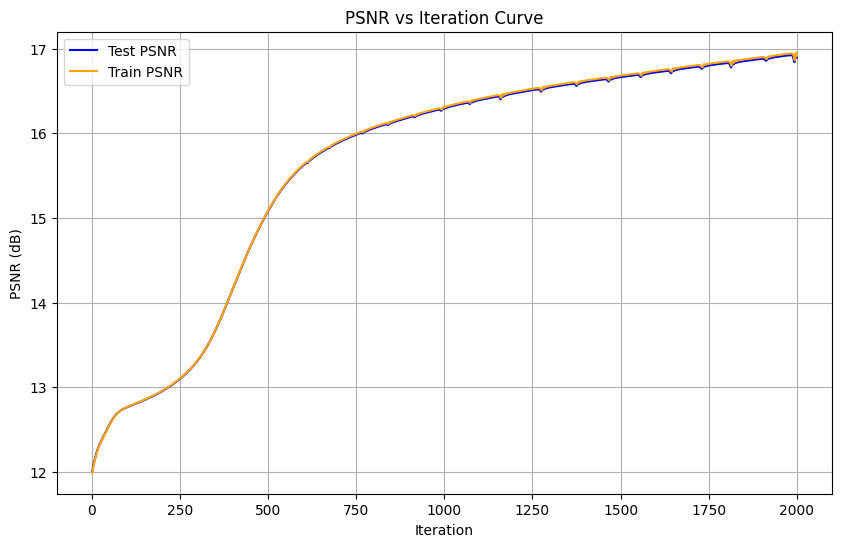

Visualizing Best Results...


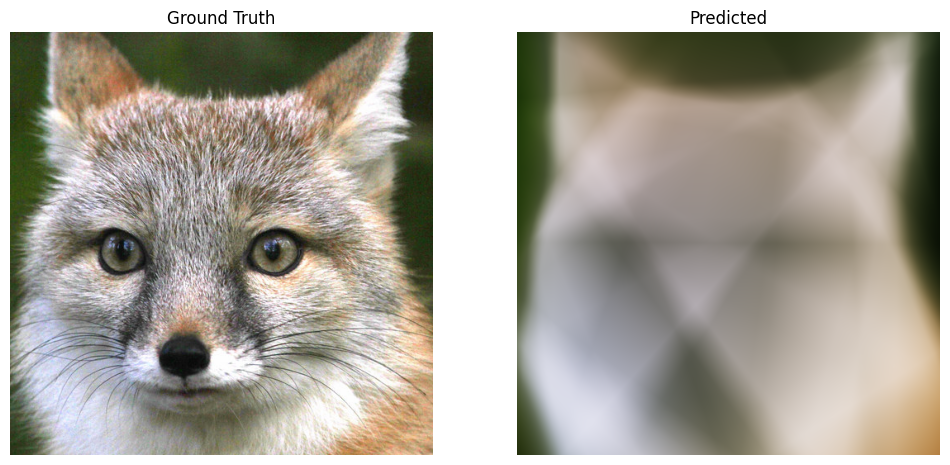

Best PSNR: 16.93 dB


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Utilities from `utilities.py`
def load_image(path):
    img = torchvision.io.read_image(path).permute(1, 2, 0)[..., :3] / 255.0  # Normalize to [0, 1]
    return img

def psnr(pred, target):
    mse = F.mse_loss(pred, target)
    return -10 * torch.log10(mse)

def display_image(img, pred_img):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(img)
    ax[0].set_title('Ground Truth')
    ax[0].axis('off')
    ax[1].imshow(pred_img)
    ax[1].set_title('Predicted')
    ax[1].axis('off')
    plt.show()

# Define the MLP model
class NeuralNetwork(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_channels, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, out_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Load and preprocess the image
print("Loading Image...")
img = load_image('image.jpg')
h, w = img.shape[0] // 2, img.shape[1] // 2
img = img[h - 256:h + 256, w - 256:w + 256]

# Prepare training and testing datasets
print("Preparing Datasets...")
train = []
test = []
target = []
ground_truth = []

for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        test.append([i / float(img.shape[0]), j / float(img.shape[1])])
        ground_truth.append(img[i][j].tolist())

for i in range(0, img.shape[0], 2):
    for j in range(0, img.shape[1], 2):
        train.append([i / float(img.shape[0]), j / float(img.shape[1])])
        target.append(img[i][j].tolist())

train = torch.tensor(train, dtype=torch.float32)
test = torch.tensor(test, dtype=torch.float32)
target = torch.tensor(target, dtype=torch.float32)
ground_truth = torch.tensor(ground_truth, dtype=torch.float32)

# Initialize the model
print("Initializing Model...")
# Initialize the model with correct input and output dimensions
m = train.shape[1]  # Number of input features (normalized coordinates: x and y)
n = target.shape[1]  # Number of output features (RGB values)
model = NeuralNetwork(in_channels=m, out_channels=n)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop for 50 iterations
print("Starting Training...")
train_psnrs = []
test_psnrs = []
best_psnr = -float('inf')
best_pred_img = None

num_iterations = 2000
for iteration in range(num_iterations):
    model.train()

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass on training data
    outputs = model(train)

    # Compute loss and backpropagate
    loss = criterion(outputs, target)
    loss.backward()

    # Optimize weights
    optimizer.step()

    # Compute PSNR for train and test sets
    with torch.no_grad():
        train_psnr = psnr(outputs.detach(), target).item()
        test_outputs = model(test)
        test_psnr = psnr(test_outputs.detach(), ground_truth).item()

        train_psnrs.append(train_psnr)
        test_psnrs.append(test_psnr)

        # Save best PSNR and corresponding predicted image
        if test_psnr > best_psnr:
            best_psnr = test_psnr
            best_pred_img = test_outputs.reshape(img.shape[0], img.shape[1], 3).numpy()
        if iteration % 10 == 0:
          print(f"Iteration [{iteration + 1}/{num_iterations}], Loss: {loss.item():.4f}, Train PSNR: {train_psnr:.2f}, Test PSNR: {test_psnr:.2f}")

# Plot PSNR vs iteration curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_iterations + 1), test_psnrs, label='Test PSNR', color='blue')
plt.plot(range(1, num_iterations + 1), train_psnrs, label='Train PSNR', color='orange')
plt.xlabel('Iteration')
plt.ylabel('PSNR (dB)')
plt.title('PSNR vs Iteration Curve')
plt.legend()
plt.grid(True)
plt.show()

# Display best output image vs original image
print("Visualizing Best Results...")
display_image(img.numpy(), best_pred_img)

print(f"Best PSNR: {best_psnr:.2f} dB")


# Task 2

Using device: cuda
Epoch: 1 | loss: 0.06453840434551239 | train_psnr: 11.901817321777344 | test_psnr: 11.915360450744629
Epoch: 101 | loss: 0.014490708708763123 | train_psnr: 18.38910484313965 | test_psnr: 18.500797271728516
Epoch: 201 | loss: 0.006029319018125534 | train_psnr: 22.19731903076172 | test_psnr: 22.022022247314453
Epoch: 301 | loss: 0.004833731334656477 | train_psnr: 23.157175064086914 | test_psnr: 22.812307357788086
Epoch: 401 | loss: 0.004128907807171345 | train_psnr: 23.84164810180664 | test_psnr: 23.284408569335938
Epoch: 501 | loss: 0.0035225581377744675 | train_psnr: 24.53141975402832 | test_psnr: 23.671445846557617
Epoch: 601 | loss: 0.0029559065587818623 | train_psnr: 25.293092727661133 | test_psnr: 24.014892578125
Epoch: 701 | loss: 0.002478586509823799 | train_psnr: 26.057958602905273 | test_psnr: 24.2860050201416
Epoch: 801 | loss: 0.0020963915158063173 | train_psnr: 26.785276412963867 | test_psnr: 24.4870662689209
Epoch: 901 | loss: 0.001796675380319357 | train

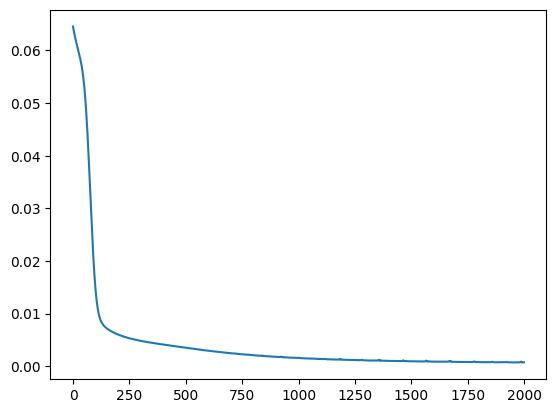

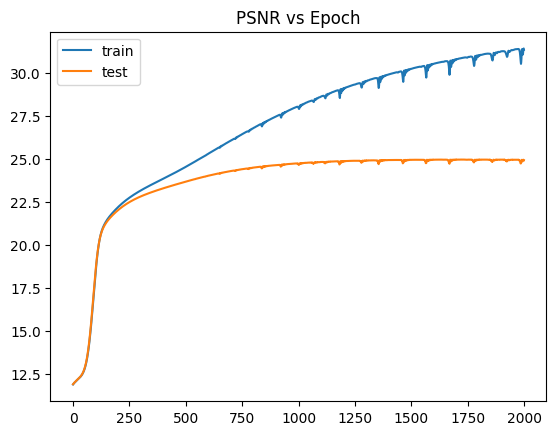

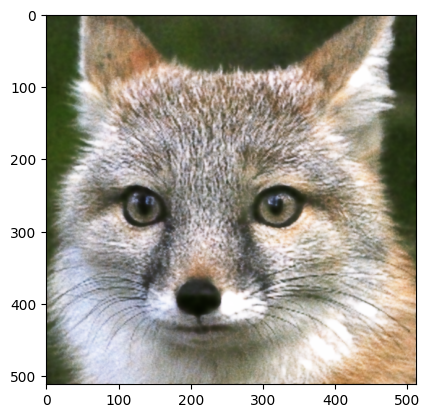

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision

# Set device (use GPU if available)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Load and preprocess the image
def load_image(path):
    img = torchvision.io.read_image(path).permute(1, 2, 0)[..., :3] / 255.0  # Normalize to [0, 1]
    return img

def psnr(pred, target):
    mse = F.mse_loss(pred, target)
    return -10 * torch.log10(mse)

# Define FFMLP model
class FFMLP(nn.Module):
    def __init__(self, n=3, d=256, s=10):
        super().__init__()
        self.fc1 = nn.Linear(2*d, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, n)
        self.B = s * torch.randn((d, 2)).to(DEVICE)

    def forward(self, x):
        x = 2 * torch.pi * x @ self.B.T
        x = torch.cat([torch.sin(x), torch.cos(x)], axis=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

# Load image
img = load_image('image.jpg')
h, w = img.shape[0] // 2, img.shape[1] // 2
img = img[h - 256:h + 256, w - 256:w + 256]

# Prepare training and testing datasets
train_inputs = []
test_inputs = []
train_outputs = []
test_outputs = []

for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        test_inputs.append([i / img.shape[0], j / img.shape[1]])
        test_outputs.append(img[i][j].tolist())

for i in range(0, img.shape[0], 2):
    for j in range(0, img.shape[1], 2):
        train_inputs.append([i / img.shape[0], j / img.shape[1]])
        train_outputs.append(img[i][j].tolist())

train_inputs = torch.tensor(train_inputs, dtype=torch.float32).to(DEVICE)
test_inputs = torch.tensor(test_inputs, dtype=torch.float32).to(DEVICE)
train_outputs = torch.tensor(train_outputs, dtype=torch.float32).to(DEVICE)
test_outputs = torch.tensor(test_outputs, dtype=torch.float32).to(DEVICE)

# Initialize model and optimizer
model = FFMLP().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.MSELoss()

def train():
    model.train()
    ops = []
    train_psnrs = []
    test_psnrs = []
    losses = []

    num_epochs = 2000
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        train_preds = model(train_inputs)
        loss = loss_fn(train_outputs, train_preds)

        loss.backward()
        losses.append(loss.item())
        optimizer.step()

        with torch.no_grad():
            train_psnrs.append(psnr(train_preds, train_outputs).cpu().numpy())
            test_preds = model(test_inputs)
            test_psnrs.append(psnr(test_preds, test_outputs).cpu().numpy())
            pred_img = test_preds.reshape(img.shape[0], img.shape[1], 3).cpu().numpy()

            if epoch % 100 == 0:
                ops.append(pred_img)
                print(f"Epoch: {epoch+1} | loss: {loss.item()} | train_psnr: {train_psnrs[-1]} | test_psnr: {test_psnrs[-1]}")

    print()
    return ops, train_psnrs, test_psnrs, losses

ops, train_psnrs, test_psnrs, losses = train()

max_idx = np.argmax(test_psnrs)
best_op = ops[max_idx // 100]

plt.plot(losses)
plt.show()

plt.plot(train_psnrs, label='train')
plt.plot(test_psnrs, label='test')
plt.title('PSNR vs Epoch')
plt.legend()
plt.show()

plt.imshow(best_op)
plt.show()


Visualizing Best Results...


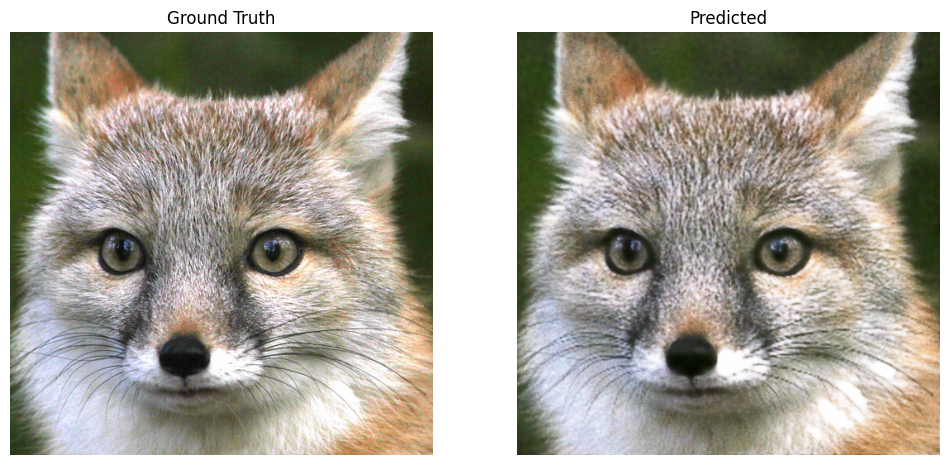

In [12]:
# Display best output image vs original image
print("Visualizing Best Results...")
display_image(img.numpy(), best_op)

In [14]:
del model

# Task 3

Epoch: 1 | loss: 0.06518112123012543 | train_psnr: 11.858781814575195 | test_psnr: 11.891227722167969
Epoch: 101 | loss: 0.021894674748182297 | train_psnr: 16.596614837646484 | test_psnr: 16.610366821289062
Epoch: 201 | loss: 0.012948637828230858 | train_psnr: 18.877758026123047 | test_psnr: 18.867725372314453
Epoch: 301 | loss: 0.01040891744196415 | train_psnr: 19.825946807861328 | test_psnr: 19.80140495300293
Epoch: 401 | loss: 0.009618541225790977 | train_psnr: 20.168907165527344 | test_psnr: 20.141483306884766
Epoch: 501 | loss: 0.008953366428613663 | train_psnr: 20.48013687133789 | test_psnr: 20.439598083496094
Epoch: 601 | loss: 0.008640619926154613 | train_psnr: 20.634552001953125 | test_psnr: 20.590055465698242
Epoch: 701 | loss: 0.008420438505709171 | train_psnr: 20.746652603149414 | test_psnr: 20.701486587524414
Epoch: 801 | loss: 0.008275464177131653 | train_psnr: 20.82207679748535 | test_psnr: 20.785730361938477
Epoch: 901 | loss: 0.00812799483537674 | train_psnr: 20.900165

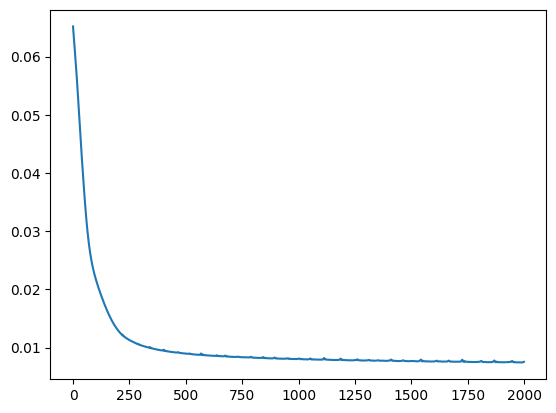

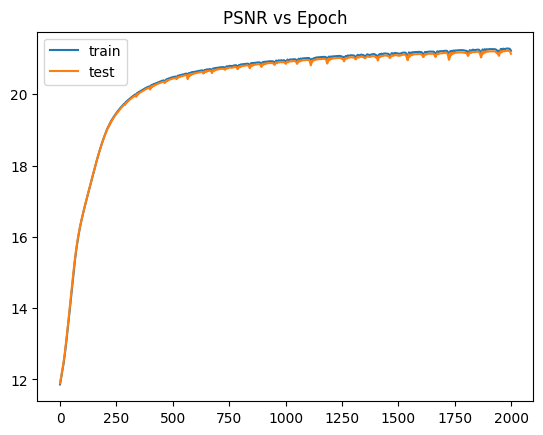

Visualizing Best Results...


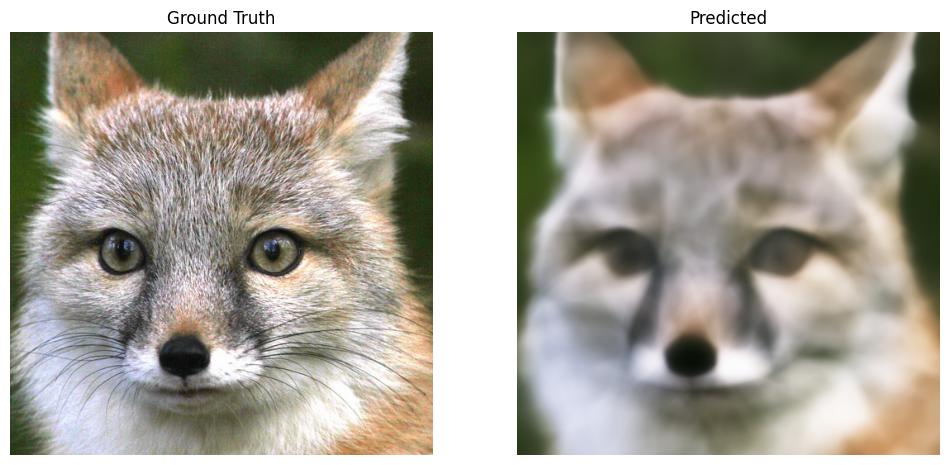

In [17]:
model = FFMLP(s=1).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.MSELoss()
ops, train_psnrs, test_psnrs, losses = train()


max_idx = np.argmax(test_psnrs)
best_op = ops[max_idx // 100]

plt.plot(losses)
plt.show()

plt.plot(train_psnrs, label='train')
plt.plot(test_psnrs, label='test')
plt.title('PSNR vs Epoch')
plt.legend()
plt.show()

# Display best output image vs original image
print("Visualizing Best Results...")
display_image(img.numpy(), best_op)

del model

Epoch: 1 | loss: 0.06613913178443909 | train_psnr: 11.795414924621582 | test_psnr: 11.811750411987305
Epoch: 101 | loss: 0.05975709855556488 | train_psnr: 12.236104965209961 | test_psnr: 12.179311752319336
Epoch: 201 | loss: 0.029253995046019554 | train_psnr: 15.338149070739746 | test_psnr: 12.615386009216309
Epoch: 301 | loss: 0.005452529992908239 | train_psnr: 22.63401985168457 | test_psnr: 11.890693664550781
Epoch: 401 | loss: 0.0027674396988004446 | train_psnr: 25.579219818115234 | test_psnr: 11.52600383758545
Epoch: 501 | loss: 0.002204178599640727 | train_psnr: 26.567533493041992 | test_psnr: 11.37281322479248
Epoch: 601 | loss: 0.0019781216979026794 | train_psnr: 27.0374698638916 | test_psnr: 11.287150382995605
Epoch: 701 | loss: 0.0018635715823620558 | train_psnr: 27.296541213989258 | test_psnr: 11.221686363220215
Epoch: 801 | loss: 0.0017959221731871367 | train_psnr: 27.457124710083008 | test_psnr: 11.17855167388916
Epoch: 901 | loss: 0.0017536388477310538 | train_psnr: 27.560

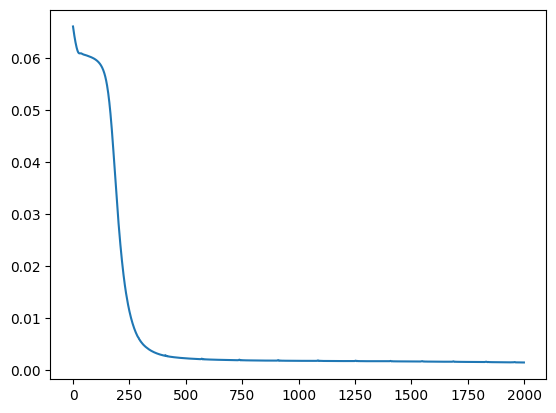

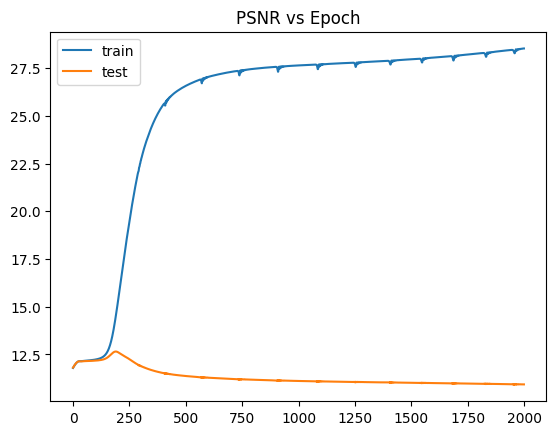

Visualizing Best Results...


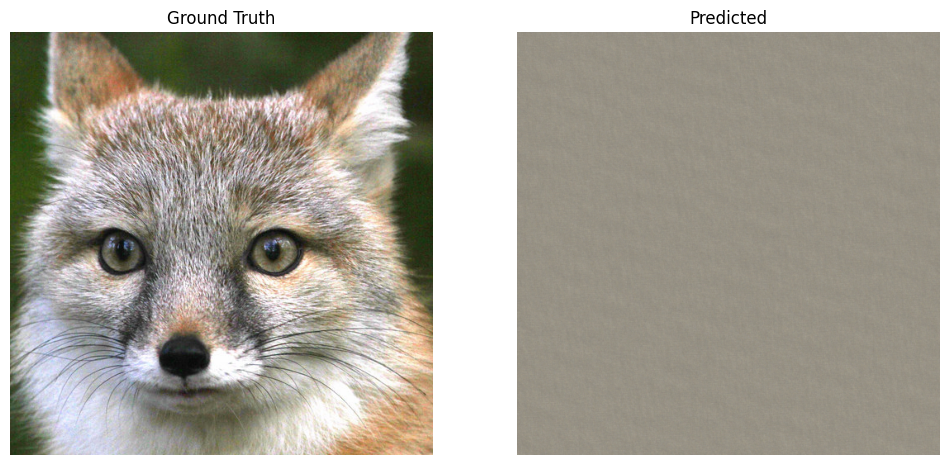

In [19]:
model = FFMLP(s=100).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.MSELoss()
ops, train_psnrs, test_psnrs, losses = train()


max_idx = np.argmax(test_psnrs)
best_op = ops[max_idx // 100]

plt.plot(losses)
plt.show()

plt.plot(train_psnrs, label='train')
plt.plot(test_psnrs, label='test')
plt.title('PSNR vs Epoch')
plt.legend()
plt.show()

# Display best output image vs original image
print("Visualizing Best Results...")
display_image(img.numpy(), best_op)

del model

Optimal value of s is ***10***

**Why are we projecting input coordinates to higher dimensional space?**

Projecting input coordinates to a higher-dimensional space using positional encoding (e.g., sine and cosine functions) helps the model capture high-frequency variations in the data. This is crucial because standard MLPs struggle to learn fine details due to their spectral bias, meaning they tend to favor low-frequency signals. By lifting the input into a higher-dimensional representation, the model can better approximate complex functions, such as sharp edges in images or high-frequency variations in signals.

**Alternative methods to sine and cosine transformations:**
While sinusoidal positional encoding is commonly used, there are several alternatives:

**Random Fourier Features (RFF):** Instead of fixed sinusoidal mappings, RFFs use randomly sampled Gaussian weights to transform the input, improving generalization in some tasks.

**Polynomial Expansions:** Instead of trigonometric functions, we can use polynomial basis functions to lift inputs into a higher space.
Wavelet Transforms: Using wavelet bases (e.g., Haar, Daubechies) instead of sine and cosine functions can provide a multi-resolution decomposition of the input.

**Learnable Embeddings:** Instead of fixed transformations, learnable neural embeddings can be trained to map coordinates into a useful high-dimensional space.